# SNODAS vs CSO

This script extracts point data from the [NASA snodas dataset](https://nsidc.org/data/g02158) at the location of CSOs.

We're aware of a few other repos that overlap with this work:

* David Hill's [matlab and shell scripts](https://github.com/dfosterhill/SNODAS)
* David Shean's [Python snowtools](https://github.com/dshean/snowtools)

This script calls the [MountainHub API](https://github.com/communitysnowobs/mountainhub-api) 

### Authors

* Jonah Joughin 
* Anthony Arendt 
* Emilio Mayorga

In [2]:
%matplotlib inline
import pandas as pd
import xarray as xr
from datetime import datetime
import seaborn as sns
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
import calendar

from validation import SNODAS, Elevation, utils as ut, creds
import mtnhubsnow as mh

## Download CSO 

In [3]:
# Restrict points to the coterminous US
region = {
    'latmax' : 50,
    'latmin' : 25,
    'lonmax': -65,
    'lonmin': -125,
}

obs = mh.snow_data(limit=10000, start=datetime(2017,10,1), end=datetime(2021,9,10), bbox=region)
obs['date'] = obs.apply(lambda row: datetime.fromisoformat(row['datetime_utc'].strftime('%Y-%m-%d')), axis=1)
obs.sort_values(by=['date'], inplace = True)
obs.head()

,id,datetime_utc,latitude,longitude,author_name,obs_type,snow_depth,description,date
3319,59e42113e2ee090b1c2ed009,2017-10-14 23:00:00+00:00,43.507211,-110.948868,Jacob Urban,snow_conditions,45.000000,Not enough snow to make safe turns. Weak basal...,2017-10-14
3318,5bfc6c771a711306b450d208,2017-10-15 19:00:00+00:00,44.401997,-121.882284,David Hill,snow_conditions,43.180000,,2017-10-15
3317,59e40df6e2ee090b1c0aeb47,2017-10-16 01:40:02.297000+00:00,46.230208,-122.150324,GoatSolo,snow_conditions,15.240000,,2017-10-16
3312,59eab71a3a0c020b158f8e62,2017-10-21 02:55:05.614000+00:00,39.749913,-105.873374,Ryo Sueda,snow_conditions,35.559999,,2017-10-21
3314,59eab3353ccff80b07dddd98,2017-10-21 02:38:44.385000+00:00,39.774098,-105.889726,Ryo Sueda,snow_conditions,25.400000,Deepest part was about 1.5 feet. only around 4...,2017-10-21


# Method 1: Extract SNODAS data for the specific day of CSO and compare

Here we iterate over each day of the year and extract only those snodas grid cells that have CSO in them. For now we're using the "nearest" method but it might be worth exploring other spatial interpolation methods. 

In [104]:
grouped = obs.groupby('date')
snodas_hs = []
n = 1
# this is to show progress over the iterations
pbar = tqdm(grouped)
for name, group in pbar:
    # get the snowdas data for each day
    date = datetime.utcfromtimestamp(group['date'].values[0].tolist()/1e9)
    pbar.set_description('processing {}, {} of {} dates'.format(date.strftime("%Y-%m-%d"), n, len(grouped)))
    ds = SNODAS.snodas_ds(date)
    tgt_x = xr.DataArray(group['longitude'].values, dims="points")
    tgt_y = xr.DataArray(group['latitude'].values, dims="points")
    for i in range(len(tgt_x)):
        snodas_hs.append(ds.sel(x=tgt_x, y=tgt_y, method='nearest').values[0][i]/1000)
    n += 1

processing 2021-09-04, 572 of 572 dates: 100%|██████████| 572/572 [2:01:30<00:00, 12.75s/it]  


## Combine results into a new dataframe

In [105]:
df = pd.DataFrame({"longitude":obs.longitude,
                   "latitude":obs.latitude, 
                   "date":obs.date,
                   "CSO_hs": obs.snow_depth.values/100, # convert from cm to m
                   "snodas_hs": snodas_hs})

### Add a new column to calculate differences between snodas and CSO

In [106]:
df['difference'] = df['snodas_hs']-df['CSO_hs']

## Serialize for later use

In [112]:
df.to_pickle('data/snodas_vs_cso')

## Start here if reading the processed data back in 

In [89]:
df = pd.read_pickle('data/snodas_vs_cso')

# Method 2: calculate statistics across the full period of SNODAS record

In [ ]:
#daterange = pd.date_range(start="2018-01-01",end="2018-01-05")
yearrange = range(2004,2020)
grouped = obs.groupby(['longitude','latitude'])
snodas_hs = []
snodas_stdev = []
snodas_1stq = []
snodas_3rdq = []

n = 1
# this is to show progress over the iterations
pbar = tqdm(grouped)
for name, group in pbar:
    gridcell_data = []
    tgt_x = xr.DataArray(group['longitude'].values, dims="points")
    tgt_y = xr.DataArray(group['latitude'].values, dims="points")
    i = 1
    for y in yearrange:
        pbar.set_description('processing {} of {} years over {} of {} grid cells'.format(i, len(yearrange), n, len(grouped)))
        date = datetime.utcfromtimestamp(group['date'].values[0].tolist()/1e9)
        try:
            d = datetime.strptime(str(date.day) + '/' + str(date.month) + '/' + str(y), '%d/%m/%Y')
            ds = SNODAS.snodas_ds(d)
            gridcell_data.append(ds.sel(x=tgt_x, y=tgt_y, method='nearest').values[0][0]/1000)
        except:
            pass
        i += 1
    statsdf = pd.DataFrame({'SNODAS_snow_depth':gridcell_data})
    snodas_hs.append(statsdf.mean().values[0])
    snodas_stdev.append(statsdf.std().values[0])
    snodas_1stq.append(statsdf.quantile(q=0.25, axis=1, numeric_only=True, interpolation='linear').values[0])
    snodas_3rdq.append(statsdf.quantile(q=0.75, axis=1, numeric_only=True, interpolation='linear').values[0])
    n += 1

processing 9 of 16 years over 2 of 2663 grid cells:   0%| | 1/2663 [04:43<139:13

In [12]:
grouped = obs.groupby(['longitude','latitude'])['longitude','latitude'].unique()

/tmp/ipykernel_83072/2542426095.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  grouped = obs.groupby(['longitude','latitude'])['longitude','latitude'].unique()


AttributeError: 'DataFrameGroupBy' object has no attribute 'unique'

In [76]:
df = pd.DataFrame({"longitude":obs.longitude,
                   "latitude":obs.latitude, 
                   "date":obs.date,
                   "CSO_hs": obs.snow_depth.values/100, # convert from cm to m
                   "snodas_hs": snodas_hs,
                   "snodas_stdev": snodas_stdev,
                   "snodas_1stq": snodas_1stq,
                   "snodas_3rdq": snodas_3rdq})

In [77]:
df['difference'] = df['snodas_hs']-df['CSO_hs']

## Error checking

According to the [snodas documentation](https://nsidc.org/sites/nsidc.org/files/G02158-V001-UserGuide_2.pdf) there should be no negative data during the time period we're working with. However I see one -9999 entry:

In [90]:
df[df['snodas_hs']<0.0]

,longitude,latitude,date,CSO_hs,snodas_hs,difference
1566,-68.79001,48.846308,2020-01-24,0.12,-9.999,-10.119


Let's remove this record for now:

In [91]:
df.drop(df[df['snodas_hs']<0.0].index, inplace = True)

## Make a scatter plot of the data

<AxesSubplot:xlabel='CSO_hs', ylabel='snodas_hs'>

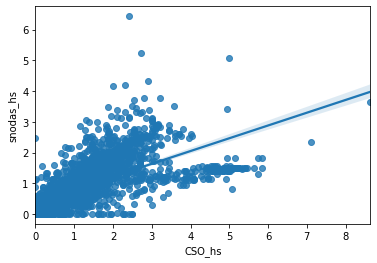

In [92]:
sns.regplot(x="CSO_hs",y="snodas_hs", data=df, truncate = True)

## Create a kernel density estimator on the difference between observations

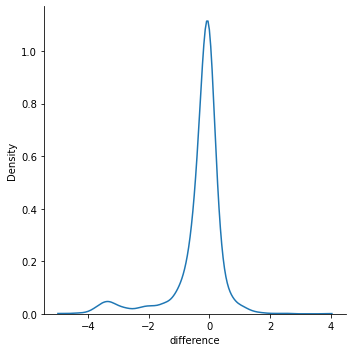

In [74]:
sns.displot(df, x='difference', kind='kde', cut = 0)

Note that the area under this curve between any two values represents the probability of the difference between CSO and snodas falling between those values. 

**Idea**: can we use this to justify filtering of gross errors in the CSO observations? For example it appears the probability of having an absolute value of the difference being 2 or greater is very low. Let's look at this plot:

<AxesSubplot:xlabel='CSO_hs', ylabel='snodas_hs'>

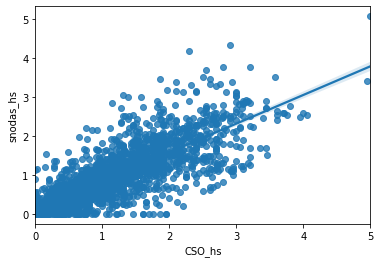

In [8]:
sns.regplot(x="CSO_hs",y="snodas_hs", data=df[abs(df['difference'])<=2], truncate = True)

## Plot temporal variability

This requires "melting" the dataframe so that all the plotted values are in a single column. 

In [82]:
df2 = pd.melt(df, 
              id_vars=['longitude','latitude','date'], 
              value_vars=['CSO_hs', 'snodas_hs'],
              value_name='snow depth (m)',
              var_name='data source')
df2['water_year'] = pd.DatetimeIndex(df2['date']).year.where(pd.DatetimeIndex(df2['date']).month < 10, pd.DatetimeIndex(df2['date']).year + 1)

Let's plot by water year. Note that this is just an aggregate over all of the coterminous US with no adjustment for elevation.

It is interesting to try these plots with and without the filtering of CSO data described above. Are the extreme CSO spikes due to high elevation measurements on those days?

I'm not yet sure about the value of these plots. It seems like a potentially useful way to show how in certain years CSO has consistently large depth observations. 

**Idea**: add a second y-axis showing number of CSO obs. in that day.

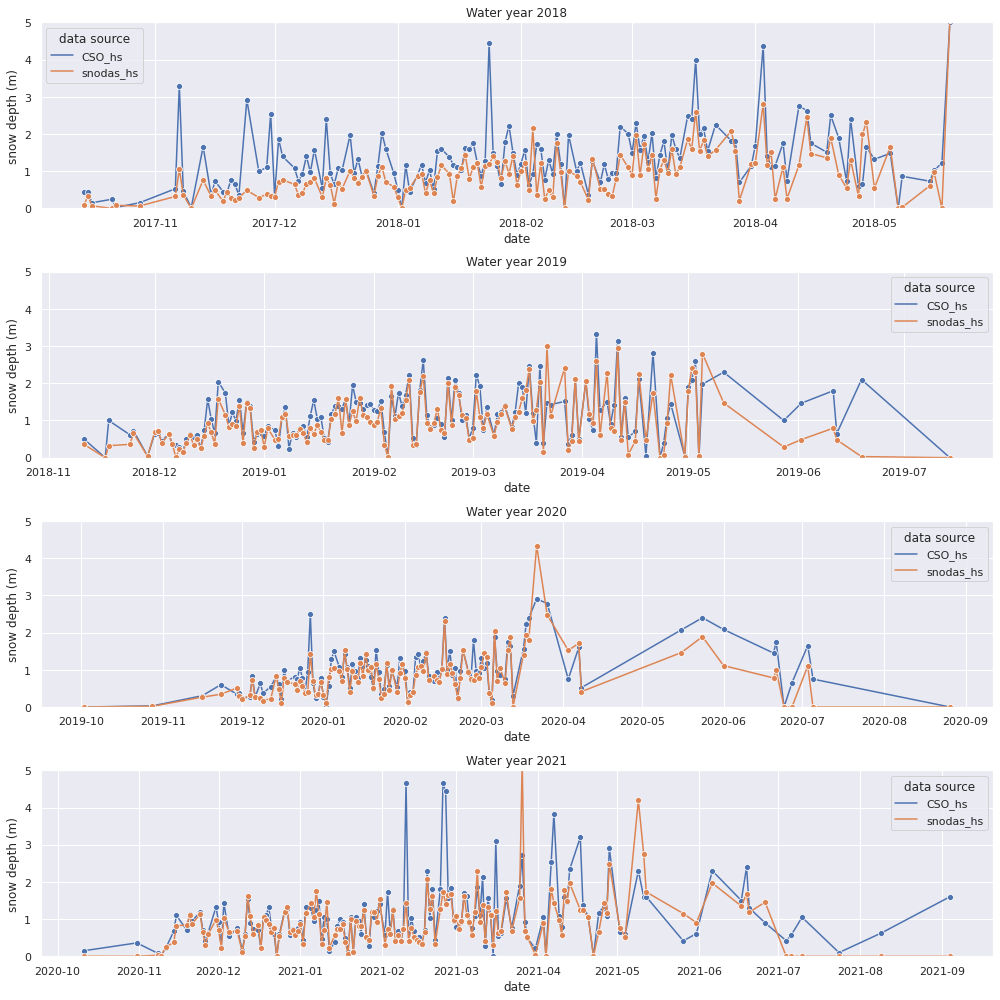

In [78]:
grouped = df2.groupby('water_year')

fig, axs = plt.subplots(nrows=grouped.ngroups, ncols=1, figsize=(14,14))

i=0
for name, group in grouped:
    axs[i] = sns.lineplot(ax = axs[i], x='date',y='snow depth (m)',data=group, hue = 'data source', marker='o', ci=None)
    axs[i].set_ylim([0,5])
    axs[i].set_title('Water year {}'.format(group['water_year'].values[0]))
    i+=1
    
plt.tight_layout(w_pad=0.5)

## Histograms

<AxesSubplot:xlabel='snow depth (m)', ylabel='Count'>

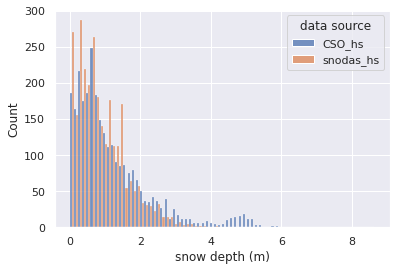

In [83]:
sns.histplot(x='snow depth (m)',data=df2, hue = 'data source', multiple='dodge')

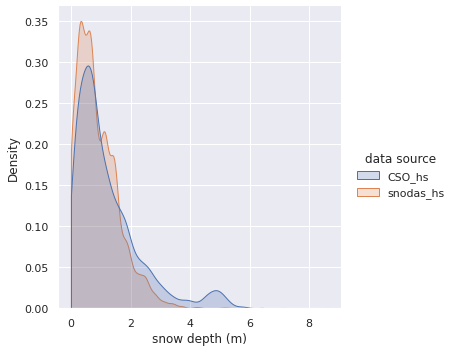

In [84]:
sns.displot(df2, x='snow depth (m)', hue = 'data source', kind='kde', cut=0, fill=True, bw_adjust=0.75)